# Библиотеки

In [338]:
from IPython.display import Image

import os
from dotenv import load_dotenv
from sqlalchemy import create_engine

import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st

from sklearn.preprocessing import PowerTransformer

# Загрузка данных

In [339]:
load_dotenv()

True

In [340]:
engine = create_engine(os.getenv('POSTGRESQL_KEY'))
connection = engine.connect()

In [341]:
train = pd.read_sql(
    '''
    SELECT *
    FROM train_data
    ''', 
    con=connection
)

test = pd.read_sql(
    '''
    SELECT *
    FROM test_data
    ''', 
    con=connection
)

In [342]:
connection.close()

# Data overview

In [343]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

### Относительно небольшое количество пропусков

In [344]:
train.describe()

,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_Credit_Inquiries,Credit_Utilization_Ratio,Total_EMI_per_month
count,84998.000000,100000.000000,100000.00000,100000.000000,100000.000000,98035.000000,100000.000000,100000.000000
mean,4194.170850,17.091280,22.47443,72.466040,21.068780,27.754251,32.285173,1403.118217
std,3183.686167,117.404834,129.05741,466.422621,14.860104,193.177339,5.116875,8306.041270
min,303.645417,-1.000000,0.00000,1.000000,-5.000000,0.000000,20.000000,0.000000
25%,1625.568229,3.000000,4.00000,8.000000,10.000000,3.000000,28.052567,30.306660
50%,3093.745000,6.000000,5.00000,13.000000,18.000000,6.000000,32.305784,69.249473
75%,5957.448333,7.000000,7.00000,20.000000,28.000000,9.000000,36.496663,161.224249
max,15204.633333,1798.000000,1499.00000,5797.000000,67.000000,2597.000000,50.000000,82331.000000


In [345]:
train.dtypes

ID                           object
Customer_ID                  object
Month                        object
Name                         object
Age                          object
SSN                          object
Occupation                   object
Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                  object
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour            object
Monthly_Balance              object
Credit_Score                

### В датасете неправильно представлены типы данных
### Одной из основных задач будет преобразование колонок к нужным типам данных

# Работа с пропусками

### Monthly_Inhand_Salary - заработок клиента банка в месяц
### Посмотрим распределение зарплат

<Axes: xlabel='Monthly_Inhand_Salary', ylabel='Count'>

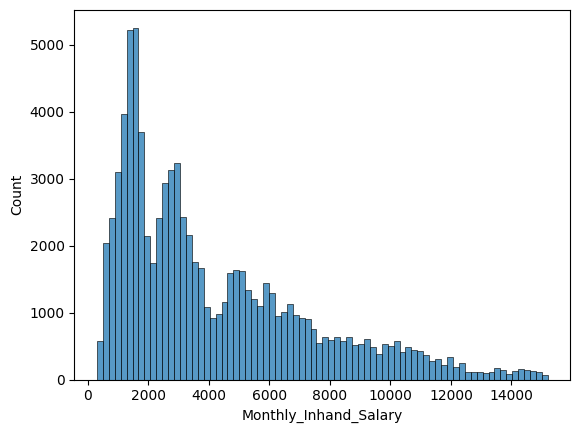

In [346]:
sns.histplot(
    train['Monthly_Inhand_Salary']
)

### Распределение похоже на логномарльное
### Приведем данные к нормальному распределению

<Axes: ylabel='Count'>

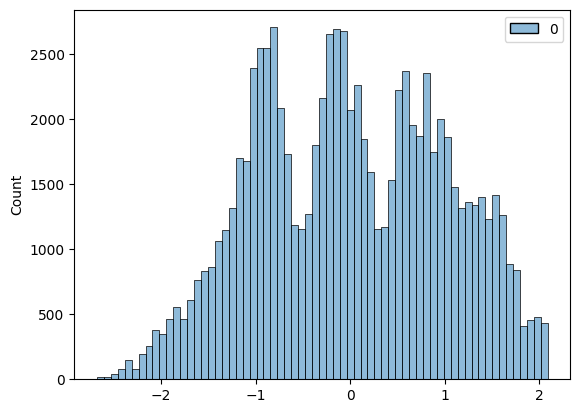

In [347]:
sns.histplot(
    PowerTransformer().fit_transform(
        np.array(train['Monthly_Inhand_Salary']).reshape(-1, 1)
    )
)

### Данные, приведенные к нормальному распределению имеют три заметных максимума

### Так как зарплата приведена в USD, данная особенность может быть связана с распределением зарплат в Соединенных Штатах

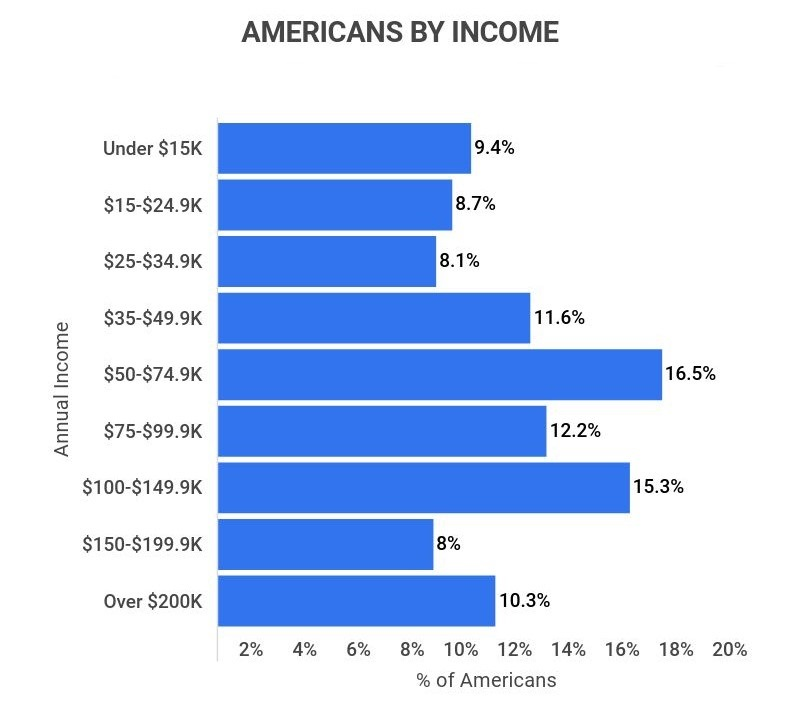

In [348]:
Image(os.getenv('LOCAL_PATH') + 'salary_distribution.jpeg')

### На это графике показано распределение зарплат жителей Америки. Легко заметить, что график похож на тот, что мы получили ранее
### Из этого можно сделать вывод, что такое распределение зарплат связано с особенностями распределения в Соединенных Штатах 

### Изучим медианное значение зарплат для каждой профессии

<Axes: xlabel='Monthly_Inhand_Salary', ylabel='Occupation'>

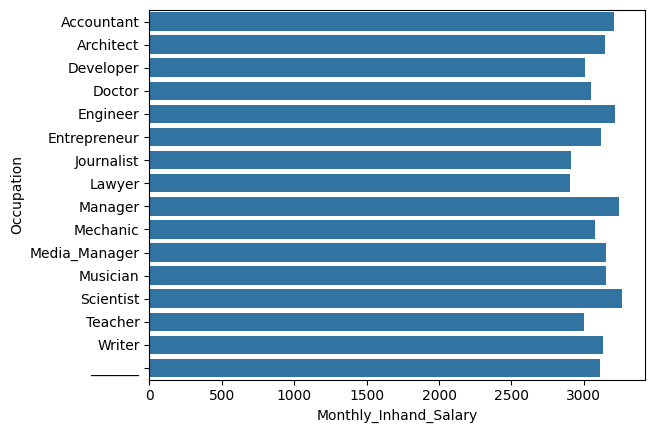

In [349]:
sns.barplot(
    x=train.groupby('Occupation')['Monthly_Inhand_Salary'].median(),
    y=train.groupby('Occupation')['Monthly_Inhand_Salary'].median().index
)

### Медианные зарплаты примерно равны, следовательно мы можем заполнить пропуски именно этими значениями

In [350]:
train['Monthly_Inhand_Salary'].fillna(train.groupby('Occupation')['Monthly_Inhand_Salary'].transform('median'), inplace=True)

### Type_of_Loan - цель займа

In [351]:
train['Type_of_Loan'].value_counts()

Type_of_Loan
Not Specified                                                                                                                         1408
Credit-Builder Loan                                                                                                                   1280
Personal Loan                                                                                                                         1272
Debt Consolidation Loan                                                                                                               1264
Student Loan                                                                                                                          1240
                                                                                                                                      ... 
Not Specified, Mortgage Loan, Auto Loan, and Payday Loan                                                                                 8
Payday Loan, M

### Удалим колонку Type_of_Loan, так как ее неудобно обрабатывать

In [352]:
train = train.drop('Type_of_Loan', axis=1)

### Num_of_Delayed_Payment - Количество просроченных выплат 
### Этот признак потенциально может испортить кредитный рейтинг клиента, так что заполнять пропуски какими-либо значениями помимо нуля, если мы не знаем количество просроченных выплат, не стоит

In [353]:
train['Num_of_Delayed_Payment'].fillna(0, inplace=True)

### Num_Credit_Inquiries - Количество запросов по кредитным картам 
### Credit_History_Age - Количество лет с момента первого кредита
### Amount_invested_monthly - Представляет собой ежемесячную сумму, инвестированную клиентом
### Monthly_Balance - Cредняя месячная сумма на балансе клиента


### Так же заполняем пропуски нулями, так как мы ничего не знаем о этих признаках клиента 

In [354]:
train['Num_Credit_Inquiries'].fillna(0, inplace=True)
train['Credit_History_Age'].fillna(0, inplace=True)
train['Amount_invested_monthly'].fillna(0, inplace=True)
train['Monthly_Balance'].fillna(0, inplace=True)

### Name - Имя клиента
### Можно заметить, что у нас существует целых 3 колонки, по которым можно идентефицировать клиента - Customer_ID, Name и SSN. Я предлагаю удалить все признаки, с помощью которых мы определяем клиента, кроме SSN

In [355]:
train.drop(
    ['ID', 'Customer_ID', 'Name'], axis=1, inplace=True
)

### Приведем тип данных оставшихся численных признаков к int или float

In [356]:
train['Amount_invested_monthly'] = pd.to_numeric(train['Amount_invested_monthly'], errors='coerce')

<Axes: xlabel='Amount_invested_monthly', ylabel='Count'>

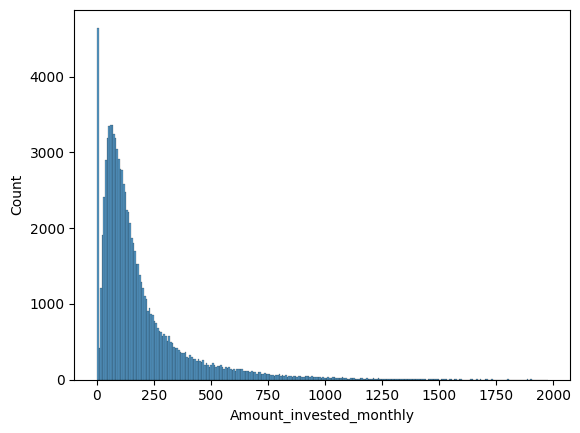

In [357]:
sns.histplot(train['Amount_invested_monthly'])

### Заметим, что большинство людей не инвестируют ничего, так что мы заполним пропуски именно этим значение

In [358]:
train['Amount_invested_monthly'] = train['Amount_invested_monthly'].fillna(st.mode(train['Amount_invested_monthly'])[0])

### При заполнение пропусков в колонке со средним балансом каждый месяц мы, фактически, заполняем не пустые значения, а некорректные, так что можем использовать в качестве меры среднего медиану

In [359]:
train['Monthly_Balance'] = pd.to_numeric(train['Monthly_Balance'], errors='coerce')
train['Monthly_Balance'] = train['Monthly_Balance'].fillna(train['Monthly_Balance'].median())

### В остальных примерах такая же ситуация. Мы заполняем пропуски, на месте которых изначально стояли некорректные значения, а не пустые

In [360]:
train['Annual_Income'] = pd.to_numeric(train['Annual_Income'], errors='coerce')
train['Annual_Income'] = train['Annual_Income'].fillna(train['Annual_Income'].median())

In [361]:
train['Credit_History_Age'] = train['Credit_History_Age'].map(lambda x: int(str(x)[0:2]))

In [362]:
train['Num_of_Loan'] = pd.to_numeric(train['Num_of_Loan'], errors='coerce')
train['Num_of_Loan'] = train['Num_of_Loan'].fillna(train['Num_of_Loan'].median())

In [363]:
train["Age"] = pd.to_numeric(train["Age"], errors="coerce")
train['Age'] = train['Age'].fillna(train['Age'].median())

In [364]:
train['Outstanding_Debt'] = pd.to_numeric(train["Outstanding_Debt"], errors="coerce")
train['Outstanding_Debt'] = train['Outstanding_Debt'].fillna(train['Outstanding_Debt'].median())

### В колонках с просроченными платежами же стоит заполнить пропуски, образовавшиеся после приведения к вещественному, нулями

In [365]:
train["Num_of_Delayed_Payment"] = pd.to_numeric(train["Num_of_Delayed_Payment"], errors="coerce")
train['Num_of_Delayed_Payment'] = train['Num_of_Delayed_Payment'].fillna(0)

### Процентное изменение лимитов по кредитной карте, в свою очередь, можно заполнить медианным значением, отражающим среднее поведение большинства людей

In [366]:
train["Changed_Credit_Limit"] = pd.to_numeric(train["Changed_Credit_Limit"], errors="coerce")
train['Changed_Credit_Limit'] = train['Changed_Credit_Limit'].fillna(train['Changed_Credit_Limit'].median())

# Преобразование категориальных колонок

In [367]:
map_table = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8
}

train['Month'] = train['Month'].replace(map_table)

In [368]:
train['Payment_Behaviour'] = train['Payment_Behaviour'].map(lambda x: 'unknown' if x == '!@9#%8' else x)

### Количество уникальных значений признака, показывающего работу, слишком большое что бы применять OHE, а MeanTargetEncoding нельзя использовать во время инференса, так что я использую похожу на преобразование месяцев схему

In [369]:
train['Occupation'] = train['Occupation'].map(lambda x: 'unknown' if x == '_______' else x)

In [370]:
occupation_map_table = {k: v for v, k in enumerate(train['Occupation'].unique())}

In [371]:
train['Occupation'] = train['Occupation'].replace(occupation_map_table)

### А вот признак, показывающий была ли выплачена лицом только минимальная сумма, идеально подходит для OHE

In [372]:
train = pd.concat((train.drop('Payment_of_Min_Amount', axis=1), pd.get_dummies(train['Payment_of_Min_Amount'], dtype=int)), axis=1)

### Так же как и фича, отражающая платежное поведение клиента

In [373]:
map_for_behaviour = {k: idx for idx, k in enumerate(train['Payment_Behaviour'].unique())}

In [374]:
train['Payment_Behaviour'] = train['Payment_Behaviour'].replace(map_for_behaviour)

### Произведем те же операции и с средним кредитным рейтингом по предыдущим запросам

In [375]:
train['Credit_Mix'] = train['Credit_Mix'].map(lambda x: 'NoData' if x == '_' else x)

In [376]:
train = pd.concat((train.drop('Credit_Mix', axis=1), pd.get_dummies(train['Credit_Mix'], dtype=int)), axis=1)

### Удалим колонку с неизвестным кредитный миксом воизбежание мультиколлениарности 

In [377]:
train = train.drop('NoData', axis=1)

### Важно закодировать значение тагрета, чтобы мы могли работать с ним. Всего у нас будет три класса:
### 0 - Poor
### 1 - Standard
### 2 - Good

In [378]:
target_map = {
    'Poor': 0,
    'Standard': 1,
    'Good': 2
}

train['Credit_Score'] = train['Credit_Score'].replace(target_map)

# Работа с выбросами

### Я предлогаю написать функцию, которая будет удалять значения, которых не существует в реальной жизни. После удаления мы будет заполнять колонки мерами среднего

In [379]:
def clear_column(column: pd.Series, values_normal_values: list) -> pd.Series:
    new_column = np.array([])

    for value in column:
        if value in values_normal_values:
            new_column = np.append(new_column, value)
        
        else:
            new_column = np.append(new_column, pd.NA)

    return pd.Series(new_column)

### Теперь проведем такую фильтрацию в нужных колонках, а так же заполним неопределенные значения

<Axes: ylabel='Age'>

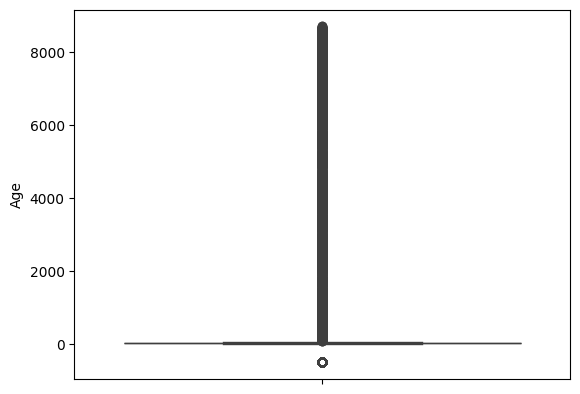

In [380]:
sns.boxplot(train['Age'])

### Можно заметить что выбросов в колонке с возрастом достаточно много. Удалим их и заменим на медианное значение

In [381]:
train['Age'] = clear_column(train['Age'], list(range(1, 100)))
train['Age'] = train['Age'].fillna(train['Age'].median())

### Проверим количество отрицательно просроченных платежей в среднем

In [382]:
train[train['Delay_from_due_date'] < 0]['Delay_from_due_date'].count()

591

### Занулим значения

In [383]:
train['Delay_from_due_date'] = clear_column(train['Delay_from_due_date'], list(range(0, max(train['Delay_from_due_date'].values))))
train['Delay_from_due_date'] = train['Delay_from_due_date'].fillna(0)

# Корреляционный отбор признаков

In [384]:
train.drop('SSN', axis=1).corr(method='spearman')

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,...,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score,NM,No,Yes,Bad,Good,Standard
Month,1.000000,0.015086,-0.000722,-0.000146,-0.002153,-0.001206,0.000223,0.000696,-0.002064,0.000537,...,0.001613,-0.000027,-0.002055,0.014433,-0.002719,0.001827,0.000017,-0.001764,0.001368,-0.000966
Age,0.015086,1.000000,0.010963,0.071436,0.063340,-0.160054,-0.117934,-0.181121,-0.165175,-0.152310,...,0.038562,0.012368,0.109684,0.141240,-0.005756,0.214444,-0.201921,-0.141591,0.160699,-0.027426
Occupation,-0.000722,0.010963,1.000000,0.004690,0.004877,0.002757,-0.009022,0.003322,-0.006019,-0.005031,...,0.003261,0.004078,0.002321,0.000413,-0.001250,0.002410,-0.001498,-0.010139,-0.007252,0.013713
Annual_Income,-0.000146,0.071436,0.004690,1.000000,0.863801,-0.244519,-0.178971,-0.258842,-0.201363,-0.222465,...,0.501219,0.163419,0.525733,0.189267,0.001043,0.242409,-0.233167,-0.200448,0.223561,-0.030160
Monthly_Inhand_Salary,-0.002153,0.063340,0.004877,0.863801,1.000000,-0.224817,-0.165937,-0.241093,-0.185273,-0.206205,...,0.486150,0.160631,0.509619,0.172654,0.002060,0.225226,-0.217348,-0.187383,0.207985,-0.027341
Num_Bank_Accounts,-0.001206,-0.160054,0.002757,-0.244519,-0.224817,1.000000,0.398657,0.553923,0.394190,0.556410,...,-0.147166,-0.035214,-0.298377,-0.377794,-0.000371,-0.505573,0.485122,0.481192,-0.518922,0.068553
Num_Credit_Card,0.000223,-0.117934,-0.009022,-0.178971,-0.165937,0.398657,1.000000,0.426859,0.323371,0.421880,...,-0.107428,-0.027004,-0.231949,-0.367471,-0.000452,-0.341223,0.327551,0.415507,-0.298643,-0.069419
Interest_Rate,0.000696,-0.181121,0.003322,-0.258842,-0.241093,0.553923,0.426859,1.000000,0.451091,0.548391,...,-0.160446,-0.045067,-0.328335,-0.460342,0.004279,-0.568858,0.542790,0.509836,-0.537386,0.063173
Num_of_Loan,-0.002064,-0.165175,-0.006019,-0.201363,-0.185273,0.394190,0.323371,0.451091,1.000000,0.400669,...,-0.125407,-0.033747,-0.429090,-0.313112,-0.001233,-0.410840,0.394827,0.460341,-0.316614,-0.092124
Delay_from_due_date,0.000537,-0.152310,-0.005031,-0.222465,-0.206205,0.556410,0.421880,0.548391,0.400669,1.000000,...,-0.139072,-0.035603,-0.289822,-0.437192,0.001652,-0.483829,0.462951,0.515916,-0.470946,-0.000621


### Удалим признаки, которые плохо коррелируют с таргетом

In [385]:
train.drop(['Month', 'Occupation', 'Credit_Utilization_Ratio', 'NM', 'Payment_Behaviour'], axis=1, inplace=True)